# File Information

Name: Amie Davis

Course: DSC680 - Data Science

Assignment: Project2 - Vet Clinic Wait Times

Purpose: Prepare Data for Modeling; Build & Evaluate Models

Usage: Python 3.7.6

   Developed using Jupter Notebook 6.0.3

# Data Source
Proprietary data provided by DoveLewis Animal Hospital, Portland, OR


# References

Albon, C. (2018). Machine learning with Python cookbook practical solutions from preprocessing to deep learning. O'Reilly. 

Mithrakumar, M. (2019, November 12). How to tune a Decision Tree? Medium. https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680. 

# Part 4

In Part 4, I will prepare the dataset for modeling.  I will also build, train, and evaluate a variety of models.

## Import required packages

In [1]:
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore') 

import csv
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from datetime import datetime

# Prepare Data

In [2]:
# Load data into pandas dataframes
data_file = "Data\modeling_data.csv"
vet_df = pd.read_csv(data_file)

#print(vet_df.columns)
#print(vet_df.dtypes)

# Exploratory Data Analysis

## Summary Statistics

In [3]:
# Review summary statistics
print("Describe Data")
print(vet_df.describe())

Describe Data
              Row ID  Outpatient Count  ICU Patient Count       Weekday  \
count   29446.000000      29446.000000       29446.000000  29446.000000   
mean   421653.889323         19.620526          19.391157      3.035862   
std      8541.990075          8.468209           4.844600      1.993248   
min    406905.000000          0.000000           5.000000      0.000000   
25%    414266.250000         14.000000          16.000000      1.000000   
50%    421627.500000         19.000000          19.000000      3.000000   
75%    428988.750000         25.000000          23.000000      5.000000   
max    436620.000000         48.000000          35.000000      6.000000   

              Month  ecc_dept_cnt  cardio_dept_cnt   im_dept_cnt  \
count  29446.000000  29446.000000     29446.000000  29446.000000   
mean       2.275895      0.233580         0.011411      0.014841   
std        1.039166      0.620678         0.109982      0.138462   
min        1.000000      0.000000     

Notice the outlier of Emergency (ECC) counts.  Max value is 73.  Upon reviewing the data, there is an almost 24-hour gap in whiteboard data, which resulted in all patients treated during that time to be assigned to the last whiteboard entry.  This outlier record will need to be removed.

## Histograms

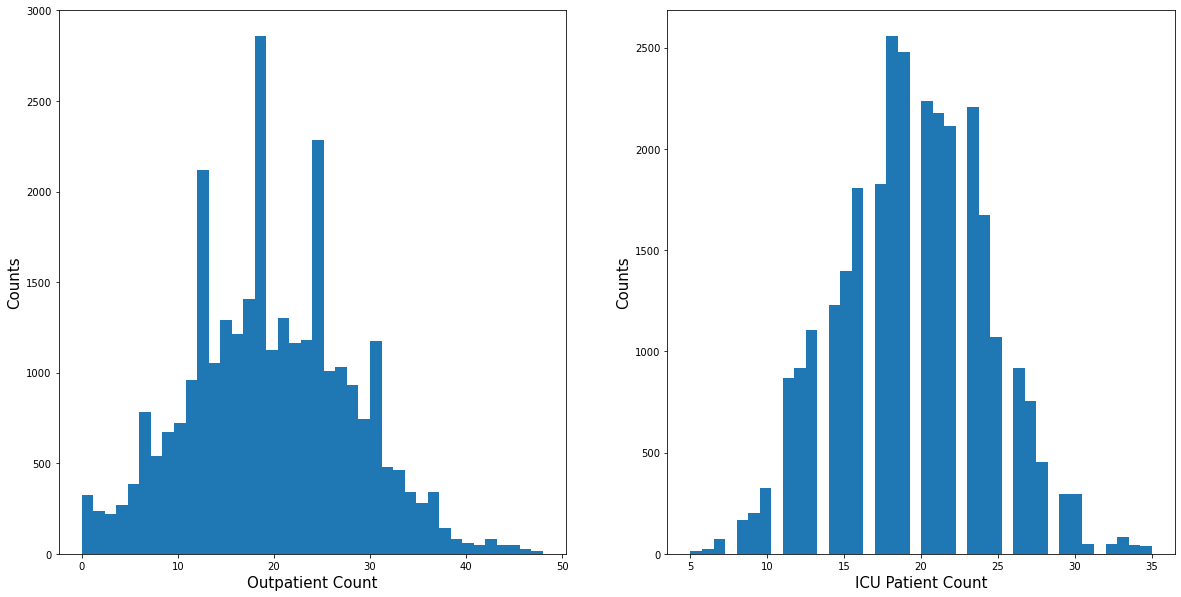

In [4]:
# Plot histograms for waiting roon counts

# Import packages
import matplotlib.pyplot as plt

# Set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)

# Make subplots
fig, axes = plt.subplots(nrows = 1, ncols = 2)

# Specify the features of interest
num_features = ['Outpatient Count', 'ICU Patient Count']
xaxes = num_features
yaxes = ['Counts', 'Counts']

# Draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.hist(vet_df[num_features[idx]].dropna(), bins=40)
    ax.set_xlabel(xaxes[idx], fontsize=15)
    ax.set_ylabel(yaxes[idx], fontsize=15)
    ax.tick_params(axis='both', labelsize=10)
    
plt.show()

## Correlation

<AxesSubplot:>

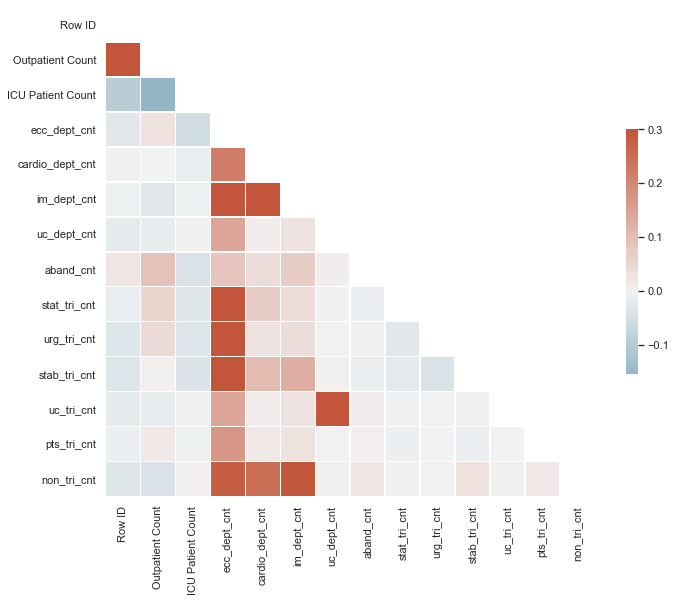

In [5]:
# Plot correlation matrix to see if numeric fields are overly correlated

# Create separate dataset with numeric features
num_df = vet_df.copy()
num_df.drop(['Time Stamp', 'Weekday', 'Month', 'Hour','Week_No'], 
        axis=1, inplace = True)

# Use Seasborn for Matrix
sns.set_theme(style="white")

# Compute the correlation matrix
corr = num_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

There is only a small correlation with each of the numeric features, so I will include all in the model.

## Determine Target Variable

Use throughput of patients as the target variable.  Will need to add a new derived column to store patient change per interval.  This will represent the throughput of the treatment area.

In [6]:
# Calculate throughput in minutes and store in df

# Sort dataframe
vet_df.sort_values(by=['Row ID'])

# Convert TimeStamp field
vet_df['Time Stamp'] = vet_df['Time Stamp'].astype('datetime64')

# Loop through each record in dataframe
last_time = 0
cur_time_int = 0
cum_int = 0
for index, row in vet_df.iterrows():
        
        # Compute patient count
        patient_cnt = row['ecc_dept_cnt'] + row['cardio_dept_cnt'] + row['im_dept_cnt'] + row['uc_dept_cnt'] 
            
        # Convert current time to days since data start date 1Jan2021
        cur_time = (row['Time Stamp'] - np.datetime64('2021-01-01','D')) / np.timedelta64(1,'D')
        cur_time = cur_time * 24 * 60    # Convert to minutes
 
        # Set time interval since the last patient change
        cur_time_int = cur_time - last_time
        cum_int = cum_int + cur_time_int
             
        # Calculate Throughput
        if patient_cnt == 0:
            patient_tput = 0
            # print(patient_cnt, cur_time, last_time, cur_time_int, cum_int, patient_tput)
        else:
            patient_tput = patient_cnt / cum_int   
            # print(patient_cnt, cur_time, last_time, cur_time_int, cum_int, patient_tput)
            cum_int = 0    #reset  
            
        # Store throughput
        vet_df.at[index,'patient_tput'] = patient_tput
            
        # Store current time for next iteration
        last_time = cur_time
        # print(patient_cnt, cum_int, patient_tput)
        
vet_df.head(10)

,Row ID,Outpatient Count,ICU Patient Count,Time Stamp,Weekday,Month,ecc_dept_cnt,cardio_dept_cnt,im_dept_cnt,uc_dept_cnt,aband_cnt,stat_tri_cnt,urg_tri_cnt,stab_tri_cnt,uc_tri_cnt,pts_tri_cnt,non_tri_cnt,Hour,Week_No,patient_tput
0,406905,14,23,2021-01-01 00:02:39,4,1,0,0,0,0,0,0,0,0,0,0,0,0,53,0.000000
1,406906,14,23,2021-01-01 00:07:41,4,1,0,0,0,0,0,0,0,0,0,0,0,0,53,0.000000
2,406907,13,23,2021-01-01 00:12:43,4,1,0,0,0,0,0,0,0,0,0,0,0,0,53,0.000000
3,406908,13,23,2021-01-01 00:17:45,4,1,0,0,0,0,0,0,0,0,0,0,0,0,53,0.000000
4,406909,12,23,2021-01-01 00:22:47,4,1,1,0,0,0,0,0,0,0,0,0,0,0,53,0.043892
5,406910,13,23,2021-01-01 00:27:50,4,1,1,0,0,0,0,0,0,0,0,0,0,0,53,0.198020
6,406911,13,23,2021-01-01 00:32:52,4,1,0,0,0,0,0,0,0,0,0,0,0,0,53,0.000000
7,406912,14,23,2021-01-01 00:37:54,4,1,0,0,0,0,0,0,0,0,0,0,0,0,53,0.000000
8,406913,13,23,2021-01-01 00:42:56,4,1,0,0,0,0,0,0,0,0,0,0,0,0,53,0.000000
9,406914,13,23,2021-01-01 00:47:58,4,1,0,0,0,0,0,0,0,0,0,0,0,0,53,0.000000


In [7]:
# Drop records without throughput
vet_df = vet_df[vet_df['patient_tput'] != 0]

# Drop outlier whiteboard record
vet_df = vet_df[vet_df['Row ID'] != 433472]

# Drop unneeded columns
vet_df.drop(['Row ID','Time Stamp'], 
        axis=1, inplace = True)

print(vet_df.columns)
vet_df.head()

Index(['Outpatient Count', 'ICU Patient Count', 'Weekday', 'Month',
       'ecc_dept_cnt', 'cardio_dept_cnt', 'im_dept_cnt', 'uc_dept_cnt',
       'aband_cnt', 'stat_tri_cnt', 'urg_tri_cnt', 'stab_tri_cnt',
       'uc_tri_cnt', 'pts_tri_cnt', 'non_tri_cnt', 'Hour', 'Week_No',
       'patient_tput'],
      dtype='object')


,Outpatient Count,ICU Patient Count,Weekday,Month,ecc_dept_cnt,cardio_dept_cnt,im_dept_cnt,uc_dept_cnt,aband_cnt,stat_tri_cnt,urg_tri_cnt,stab_tri_cnt,uc_tri_cnt,pts_tri_cnt,non_tri_cnt,Hour,Week_No,patient_tput
4,12,23,4,1,1,0,0,0,0,0,0,0,0,0,0,0,53,0.043892
5,13,23,4,1,1,0,0,0,0,0,0,0,0,0,0,0,53,0.198020
12,11,24,4,1,1,0,0,0,0,0,0,0,0,0,0,1,53,0.028382
28,9,25,4,1,1,0,0,0,0,0,0,0,0,0,0,2,53,0.012412
57,1,26,4,1,1,0,0,0,0,0,0,0,0,0,0,4,53,0.006849


## Split Dataset

In [8]:
# Split data into two sets: Training and Testing

# Rename for readability
df = vet_df

# Split out target variable
data_model_y = df.patient_tput

# Remove target variable from feature list
data_model_X = df.drop(['patient_tput'], axis=1, inplace = False)

# Split the data into training and validation datasets
# Save 30% for validation
X_train, X_val, y_train, y_val = train_test_split(data_model_X, data_model_y, test_size =0.3, random_state=7)

# Check details of the datasets
print("No. of samples in original set: ", data_model_X.shape[0])
print("No. of samples in training set: ", X_train.shape[0])
print("No. of samples in validation set: ", X_val.shape[0])
print("No. of features: ", X_train.shape[1])

No. of samples in original set:  6627
No. of samples in training set:  4638
No. of samples in validation set:  1989
No. of features:  17


In [9]:
#data_model_y
data_model_X

,Outpatient Count,ICU Patient Count,Weekday,Month,ecc_dept_cnt,cardio_dept_cnt,im_dept_cnt,uc_dept_cnt,aband_cnt,stat_tri_cnt,urg_tri_cnt,stab_tri_cnt,uc_tri_cnt,pts_tri_cnt,non_tri_cnt,Hour,Week_No
4,12,23,4,1,1,0,0,0,0,0,0,0,0,0,0,0,53
5,13,23,4,1,1,0,0,0,0,0,0,0,0,0,0,0,53
12,11,24,4,1,1,0,0,0,0,0,0,0,0,0,0,1,53
28,9,25,4,1,1,0,0,0,0,0,0,0,0,0,0,2,53
57,1,26,4,1,1,0,0,0,0,0,0,0,0,0,0,4,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28120,23,12,6,4,1,0,0,0,0,0,0,0,0,0,0,22,14
28122,27,12,6,4,1,0,0,0,0,0,0,0,0,0,0,22,14
28123,27,13,6,4,2,0,0,0,0,0,0,0,0,0,0,22,14
28129,28,13,6,4,1,0,0,0,0,0,0,0,0,0,0,23,14


# Model Evaluation and Selection

## Decision Tree Regressor

No need to encode or scale data for Decision Trees.  This will make results more explainable for customer.

### Build Model

In [10]:
# Load libraries
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets

# Create decision tree regressor object
# Use Mean Absolute Error (MAE) for metric since not concerned about smaller errors
decisiontree = DecisionTreeRegressor(criterion="mae", random_state=0)
# max_depth - Maximum depth of the tree
# min_impurity_split - Minimum impurity decrease required before a split is performed.

# Train model
tree_model = decisiontree.fit(X_train, y_train)

### Model Evaluation

In [11]:
# Return the coefficient of determination of predictions
tree_model.score(X_val, y_val, sample_weight=None)

-0.378654953986185

In [12]:
print('Tree depth:',tree_model.get_depth())
print('Number of leaves:',tree_model.get_n_leaves())

Tree depth: 51
Number of leaves: 4252


## Random Forest Regressor

### Build Model

In [13]:
# Create random forest regressor object
from sklearn.ensemble import RandomForestRegressor
randomforest = RandomForestRegressor(random_state=0, n_jobs=-1)
# max_features - maximum number of features to consider at each node. Defaults to number of features
# bootstrap - indicates whether or not to sample with replacement. Defaults to True.
# n_estimators - number of decision trees to construct. Defaults to 10.

# Train model
forest_model = randomforest.fit(X_train, y_train)

### Model Visualization

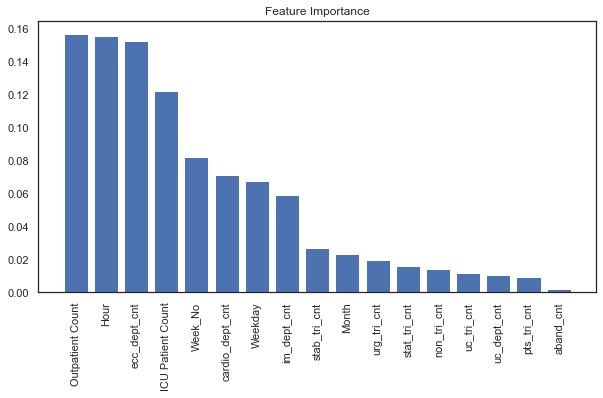

In [14]:
# Find most important features in Random Forest model

# Set up the figure size
plt.rcParams['figure.figsize'] = (10, 5)

# Calculate feature importances
importances = forest_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X_train.shape[1]), names, rotation=90)

# Show plot
plt.show()

### Re-Train

In [15]:
# Retrain the model using only the most important features
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(randomforest, threshold=0.04)

# Create new feature matrix using selector
features_important = selector.fit_transform(X_train, y_train)

# Train random forest using most important features
forest_model = randomforest.fit(features_important, y_train)


### Model Evaluation

In [16]:
# Remove non-important features from validation dataset
forest_X_val = X_val.drop(['stab_tri_cnt', 'Month', 'urg_tri_cnt','uc_tri_cnt','stat_tri_cnt','non_tri_cnt','uc_dept_cnt','pts_tri_cnt','aband_cnt'], axis=1, inplace = False)

In [17]:
# Return the coefficient of determination of predictions
forest_model.score(forest_X_val, y_val, sample_weight=None)

0.09620358586505828

## AdaBoost Regressor

### Build Model

In [18]:
# Create random forest regressor object
from sklearn.ensemble import AdaBoostRegressor
adaboost = AdaBoostRegressor(random_state=0)
# n_estimators - number of models to iteratively train
# learning_rate - contribution of each model to the weights - defaults to 1 - Reduce slower but better perf

# Train model
boost_model = adaboost.fit(X_train, y_train)

### Model Evaluation

In [19]:
# Return the coefficient of determination of the prediction.
boost_model.score(X_val, y_val, sample_weight=None)

0.023139914620062152

# Model Tuning

Optimize the highest performing model.  Decision Tree model far outperformed the others.

### Build Model

In [20]:
# Train with important features as identified by Random Forest model
imp_X_train = X_train.drop(['stab_tri_cnt', 'Month', 'urg_tri_cnt','uc_tri_cnt','stat_tri_cnt','non_tri_cnt','uc_dept_cnt','pts_tri_cnt','aband_cnt'], axis=1, inplace = False)
imp_X_val = X_val.drop(['stab_tri_cnt', 'Month', 'urg_tri_cnt','uc_tri_cnt','stat_tri_cnt','non_tri_cnt','uc_dept_cnt','pts_tri_cnt','aband_cnt'], axis=1, inplace = False)


In [21]:
# Create decision tree regressor object - Optimized to R2=0.51
decisiontree2 = DecisionTreeRegressor(
    criterion="poisson", 
    random_state=0, 
    splitter="random", 
    max_features="sqrt"
)
# max_depth - Maximum depth of the tree
# min_impurity_split - Minimum impurity decrease required before a split is performed.

# Train model
tree_model2 = decisiontree2.fit(imp_X_train, y_train)

### Model Evaluation

In [22]:
# Return the coefficient of determination of predictions
tree_model2.score(imp_X_val, y_val, sample_weight=None)

-0.5875260985662087

Limiting features increased coefficient from -0.38 to -0.44. 
Changing the criterion metric from mae to poisson increased further to -0.49.
Selecting the best random split increased to -0.51.
Considering the square root of the number of features at each decision increased further to -0.59.

In [23]:
print('Tree depth:',tree_model2.get_depth())
print('Number of leaves:',tree_model2.get_n_leaves())

Tree depth: 32
Number of leaves: 3970


### Model Visualization

In [24]:
import pydotplus
from IPython.display import Image
from sklearn import tree

# Create DOT data
dot_data = tree.export_graphviz(decisiontree,
                                out_file=None)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Save image
graph.write_png("tree_viz.png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.227615 to fit



True

# Model Deployment

In [25]:
# Review features
imp_X_val.head()
y_val.head()

13179    0.396040
4498     0.066225
9151     0.066152
11561    0.198020
17713    0.024763
Name: patient_tput, dtype: float64

In [28]:
# Prompt for feature values
p_out_wait_cnt = input('Enter number of patients currently waiting in the Outpatient Waiting Room  ')
p_icu_wait_cnt = input('Enter number of patients currently waiting in the ICU Waiting Room  ')
p_ecc_cnt = input('Enter number of patients checked in for the ECC Dept  ')
p_cardio_cnt = input('Enter number of patients checked in for the CARDIO Dept  ')
p_im_cnt = input('Enter number of patients checked in for the IM Dept  ')

# Derived date features based on current time
now = datetime.now()
p_week_no = now.isocalendar()[1]
p_week_day = now.weekday()
p_hour = now.hour

# Pass parameters into dataframe
df = pd.DataFrame({'Outpatient Count':p_out_wait_cnt,
        'ICU Patient Count':p_icu_wait_cnt,
        'Weekday':p_week_no,
        'ecc_dept_cnt':p_ecc_cnt,
        'cardio_dept_cnt':p_cardio_cnt,
        'im_dept_cnt':p_im_cnt,
        'Hour':p_hour,
        'Week_No':p_week_no},
        index=[0])
        
# Predict throughput for provided feature values
v_throughput = tree_model2.predict(df)
print()
print('Throughput is expected to be', int(round(float(v_throughput)*60,0)), 'patients per hour.')

# Calculate estimated wait time
v_wait_cnt = int(p_out_wait_cnt) + int(p_icu_wait_cnt)
v_wait_time = v_wait_cnt / v_throughput 
print('Current wait time is estimated to be', int(round(float(v_wait_time),0)), 'minutes.')

Enter number of patients currently waiting in the Outpatient Waiting Room  12
Enter number of patients currently waiting in the ICU Waiting Room  12
Enter number of patients checked in for the ECC Dept  1
Enter number of patients checked in for the CARDIO Dept  1
Enter number of patients checked in for the IM Dept  0

Throughput is expected to be 8 patients per hour.
Current wait time is estimated to be 182 minutes.
